<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/intro_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Getting started - MCHMC sampling from a Standard Gaussian target distribution**

## Setup

First, let's import the MCHMC code.

In [1]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

Cloning into 'MicroCanonicalHMC'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 469 (delta 161), reused 118 (delta 57), pack-reused 212
Receiving objects: 100% (469/469), 710.20 KiB | 10.44 MiB/s, done.
Resolving deltas: 100% (288/288), done.


We will be using jax, as it can automatically compute gradients.

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from MicroCanonicalHMC import mchmc

In this example we will sample from a standard Gaussian target. Let's define the negative log density:

In [4]:
nlogp = lambda x: 0.5*jnp.sum(jnp.square(x))

and get the gradient with jax:

In [5]:
grad_nlogp = jax.grad(nlogp)


The target is a class with functions `nlogp`, `grad_nlogp` and `transform`. Some common targets are implemented in `targets.py`.
Let's here define the standard Gaussian target:

In [6]:
class StandardGaussian():
  
  def __init__(self, d):
    self.d = d
  
  def nlogp(self, x):
     return nlogp(x)

  def grad_nlogp(self, x):
     return grad_nlogp(x)

  def transform(self, x):
    return jnp.array([x[0], jnp.sum(jnp.square(x))])

  def prior_draw(self, key):
    """Args: jax random key
       Returns: one random sample from the prior (this is used for initializing the chain in parallel mode)"""

    return jax.random.normal(key, shape = (self.d, ), dtype = 'float64') * 4

`transform` is useful when the dimensionality is high and storing all of the samples becomes memory intesive. We are ususally only iterested in some lower dimensional marginal distribution. `transform` is used in those cases as a map to the lower dimensional space of interest. As an illustration we will here only store $x_1$ and $\sum_{i=1}^d x_i^2$. If not needed it can just be set to the identity.

`prior_draw` must be defined if we want to run parallel chains. It is used to initialize each chain by drawing a random sample from the prior.

##Sequential Sampling

Let's sample from a $d = 100$ Standard Gaussian target. We create a mchmc Sampler class by passing it the desired target distribution:

In [7]:
d= 100
sampler = mchmc.Sampler(StandardGaussian(d))

We used the default gradual momentum decoherence mechanism (`generalized= True`) and the Minimal Norm integrator of the dynamics (`integrator= 'MN'`).

MCHMC has two hyperparameters, the integration step-size $ϵ$ and the momentum decoherence scale $L$. Let's use a short prerun to tune them:

In [8]:
sampler.tune_hyperparameters()

1.0009018928928382 3.814697265625e-05 1.0009018928928382 16.190861620062105
0.9851612963854789 1.6953841937730858 0.9851612963854789 12.434716724258008
0.9910508057363797 0.8418083752729034 0.9910508057363797 13.552807659492156
0.9894332425865123 0.9999599389681902 0.9894332425865123 13.553079137378328
0.9894326431658678 1.000049163266545 0.9894326431658678 13.552745992841064
-------------


We can now run the sampler. Let's get 5000 samples.

In [9]:
samples, weights = sampler.sample(5000)

The sampler returns the samples and the associated weights.

In [10]:
print(jnp.shape(samples))
print(jnp.shape(weights))

(5000, 2)
(5000,)


Let's plot the one dimensional marginal distribution along the $x_1$ coordinate.

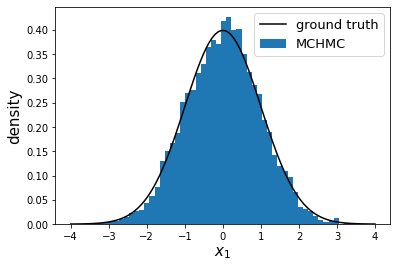

In [13]:
plt.hist(samples[:, 0], bins = 50, weights = weights, density = True, label = 'MCHMC')

from scipy.stats import norm

t = jnp.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()

Alternatively, we can avoid the weights for ploting purposes and resample according to the weights:

In [14]:
x1 = np.random.choice(samples[:, 0], 50000, p= weights / np.sum(weights))

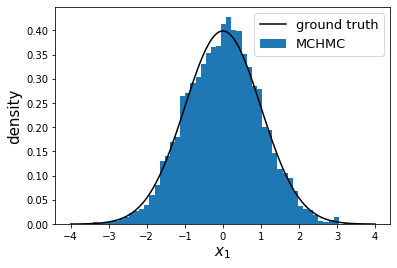

In [15]:
plt.hist(x1, bins = 50, density = True, label = 'MCHMC')

plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()

##Parallel sampling

Instead of runing one long chain we can run multiple shorter chains. Our target must now have `prior_draw` defined as this is used for initializing the chains. We will run 500 chains for 200 steps:

In [16]:
samples, weights = sampler.parallel_sample(500, 200)

In [17]:
print(np.shape(samples))
print(np.shape(weights))

(500, 200, 2)
(500, 200)


Let's assign each chain as a whole an equal weight, by normalizing the sum of all weights in each chain:

In [18]:
weights = (weights.T / np.average(weights, axis = 1)).T

The samples from all chains are now combined in a single array with `np.concatenate`. The marginal posterior looks good:

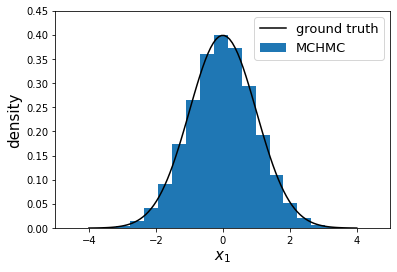

In [19]:
plt.hist(np.concatenate(samples[:, :, 0]), bins = 50, weights = np.concatenate(weights), density = True, label = 'MCHMC')

t = jnp.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.xlim(-5, 5)
plt.ylim(0, 0.45)
plt.show()